In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec


# 1. Exploración de datos


In [201]:
df_data = pd.read_excel(r"Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


## 1.1 Calidad de datos

### 1.1.1 Completitud

Se observa que no hay valores nulos en el dataset, hay 2424 filas y 2 columnas, y para cada columna ha 2424 valores no nulos. La columna `textos` es de tipo objeto (string) y la columna `labels` es de tipo entero (int64).


In [202]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [203]:
df_data.columns

Index(['textos', 'labels'], dtype='object')

In [204]:
df_data.count()

textos    2424
labels    2424
dtype: int64

In [205]:
# Valores nulos por columna
print("Datos Nulos")
print(df_data.isnull().sum())

Datos Nulos
textos    0
labels    0
dtype: int64


In [206]:
# Eliminar filas sin texto o etiqueta
df = df_data.dropna(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

In [207]:
# verificar si hay textos con strings vacíos
num_empty = (df["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

Número de textos vacíos: 0


### 1.1.2 Unicidad

Se observa que no hay duplicados en el dataset.


In [208]:
duplicados = df.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

Duplicados encontrados: 0


In [209]:
# 6. Eliminar duplicados exactos (mismo texto y misma etiqueta)
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

### 1.1.3 Validez

Revisar que todas las opiniones estén en el mismo idioma (español) y que las etiquetas sean del conjunto {1, 3, 4}.


In [210]:
# se demora alrededor de 20 segundos
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


df["language"] = df["textos"].apply(detect_language)

print(len(df[df["language"] != "es"]))

0


In [211]:
# clases en el datset
df["labels"].unique()

array([4, 3, 1], dtype=int64)

Todos los textos están en español, no se encontraron textos en otros idiomas.


In [212]:
df = df.drop(columns=["language"])

### 1.1.4 Consistencia


In [213]:
df["word_count"] = df["textos"].apply(lambda x: len(str(x).split()))

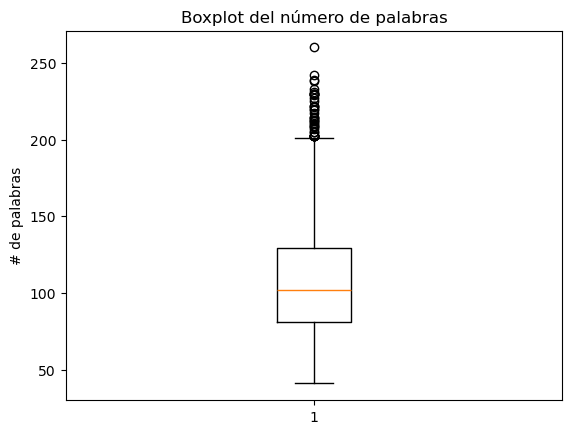

In [214]:
plt.boxplot(df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

Se observan outliers en textos que tienen una alta cantidad de palabras.


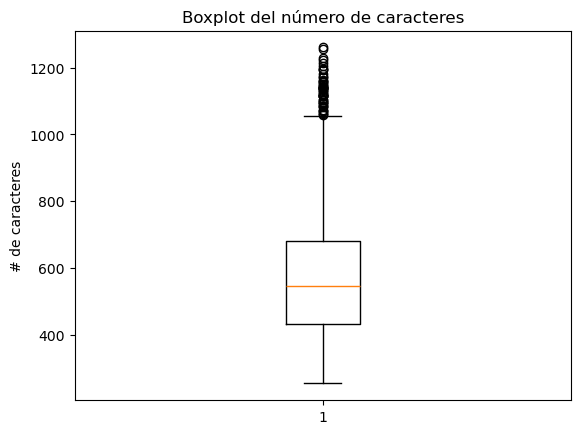

In [215]:
df["character_count"] = df["textos"].apply(lambda x: len(str(x.replace(" ", "").strip())))
plt.boxplot(df["character_count"])
plt.title("Boxplot del número de caracteres")
plt.ylabel("# de caracteres")
plt.show()
df = df.drop(columns=["character_count"])

# 2. Preparación de datos y continuación de la exploración


## 2.1 Tokenización y limpieza de texto

1. Definir función para limpiar y tokenizar el texto.
2. Aplicar la función a la columna "textos" y almacenar el resultado en una nueva columna.
3. Crear un dataframe de palabras tokenizadas para análisis posterior.


In [216]:
wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words("spanish"))


def tokenize_text(text):
    # Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r"[^a-zA-Z\s]", "", text, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # Tokenizar documento
    tokens = wpt.tokenize(doc)
    # Filtrar palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Recrear documento de texto
    doc = " ".join(filtered_tokens)
    return doc, filtered_tokens


normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x))
)

# recalcular word_count
normalized_df["word_count"] = normalized_df["textos"].apply(
    lambda x: len(str(x).split())
)

In [217]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educacin consideran sinnimos escol...,"[aprendizaje, educacin, consideran, sinnimos, ..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,nios ms pequeos bebs nios pequeos capacitacin ...,"[nios, ms, pequeos, bebs, nios, pequeos, capac..."
2,"Además, la formación de especialistas en medic...",3,93,adems formacin especialistas medicina general ...,"[adems, formacin, especialistas, medicina, gen..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,pases ocde tiende pasar cursos obligatorios op...,"[pases, ocde, tiende, pasar, cursos, obligator..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centr personas padecen trastornos mental...,"[grupo, centr, personas, padecen, trastornos, ..."


## 2.2 Exploración de distribución de datos


### 2.2.1 Análisis de balance de clases


In [218]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


In [219]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

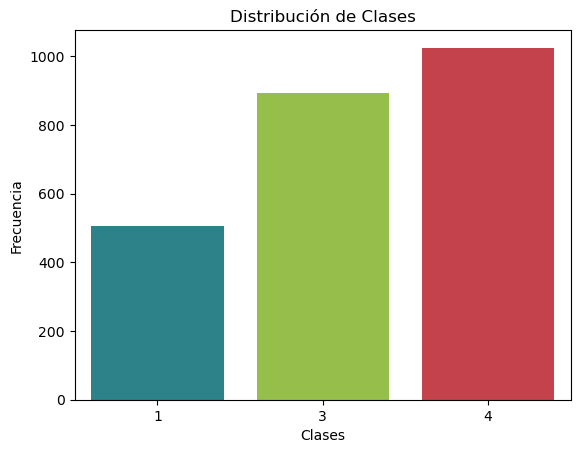

In [220]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

Las clases 4 y 3 tienen una mayor representación en el dataset, mientras que las clases 1 tiene una representación menor.


### 2.2.2 Análisis de la distribución del número de palabras por clase


Se verifica que la diferencia entre las medias de la longitud de los textos de cada clase no sea significativa con una prueba _ANOVA_.


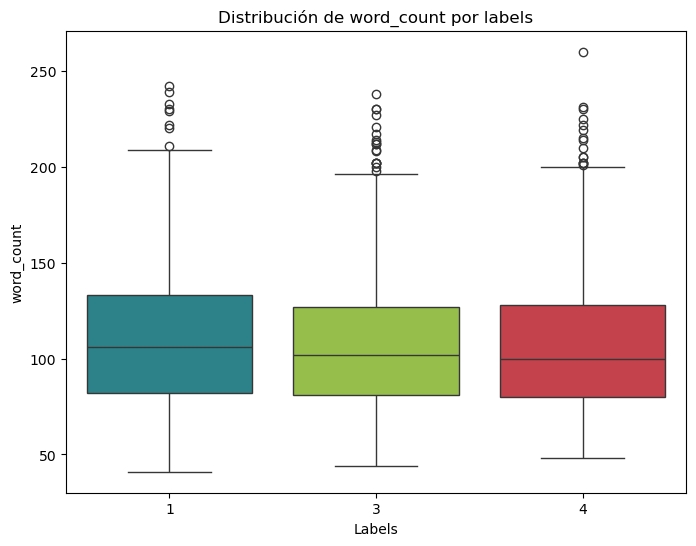

In [221]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="labels", y="word_count", data=df, palette=colors, hue="labels", legend=False
)

plt.title("Distribución de word_count por labels")
plt.xlabel("Labels")
plt.ylabel("word_count")
plt.show()

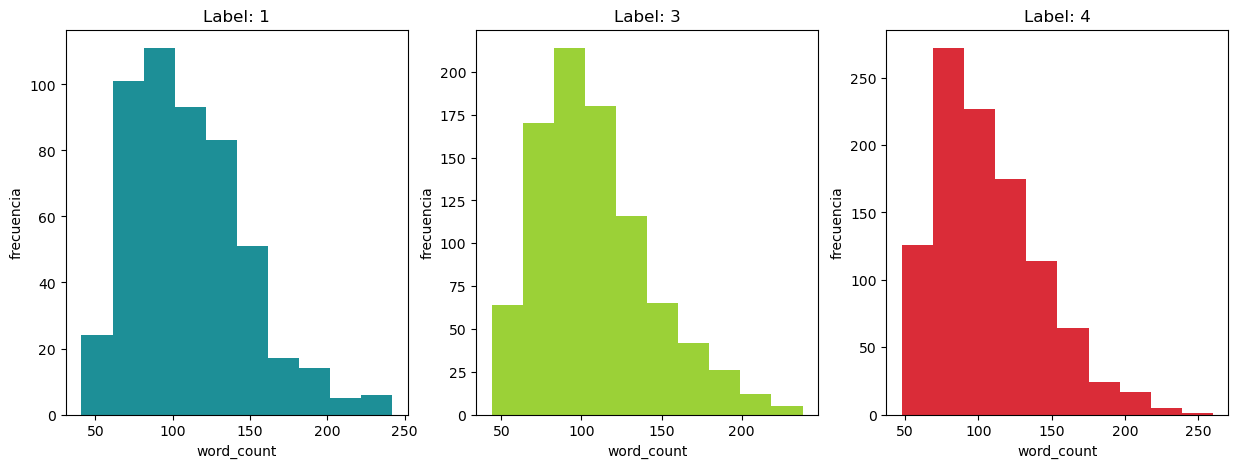

In [222]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate(sorted(df["labels"].unique())):
    ax[i].hist(df[df["labels"] == label]["word_count"], color=colors[label])
    ax[i].set_xlabel("word_count")
    ax[i].set_ylabel("frecuencia")
    ax[i].set_title(f"Label: {label}")


plt.show()

Hipótesis Nula ($H_0$): No hay diferencia en la media de la variable numérica `word_count` para todos los grupos: $ \mu_1 = \mu_3 = \mu_4 $.

Hipótesis Alterna ($H_1$): Hay una diferencia en la media de la variable numérica `word_count` para al menos uno de los grupos: $ \mu_i \neq \mu_j $ para al menos un par $(i, j)$, donde $i, j \in \{1, 3, 4\}$ y $i \neq j$.


In [223]:
label1_group = normalized_df[normalized_df["labels"] == 1]["word_count"]
label3_group = normalized_df[normalized_df["labels"] == 3]["word_count"]
label4_group = normalized_df[normalized_df["labels"] == 4]["word_count"]

f_statistic, p_value = f_oneway(label1_group, label3_group, label4_group)

print("Resultados del Test ANOVA:")
print("=" * 30)
print(f"Estadístico F: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print("=" * 30)

alpha = 0.05

print("Interpretación:")
if p_value < alpha:
    print(f"p-value ({p_value:.4f}) es menor que {alpha}.")
    print("Se rechaza la hipótesis nula (H0).")
    print(
        "Conclusión: Existe una diferencia estadísticamente significativa en la media de 'word_count' de al menos uno de los grupos."
    )
else:
    print(f"p-value ({p_value:.4f}) es mayor que {alpha}.")
    print("No se puede rechazar la hipótesis nula (H0).")
    print(
        "Conclusión: No hay evidencia suficiente para afirmar que las medias de 'word_count' son diferentes entre los grupos."
    )

Resultados del Test ANOVA:
Estadístico F: 1.8812
P-value: 0.1526
Interpretación:
p-value (0.1526) es mayor que 0.05.
No se puede rechazar la hipótesis nula (H0).
Conclusión: No hay evidencia suficiente para afirmar que las medias de 'word_count' son diferentes entre los grupos.


Dado el resultado de la prueba _ANOVA_ de una vía con $\alpha = 0.05$, no se puede rechazar la hipótesis nula, lo que indica que no hay evidencia suficiente para afirmar que existen diferencias significativas en la media de la variable `word_count` entre las diferentes clases.

De este modo, se tiene claridad en que la longitud de los textos no introduce un sesgo significativo en el análisis de las opiniones clasificadas en las diferentes clases.


### 2.2.3 Distribución del número de palabras en todo el dataset


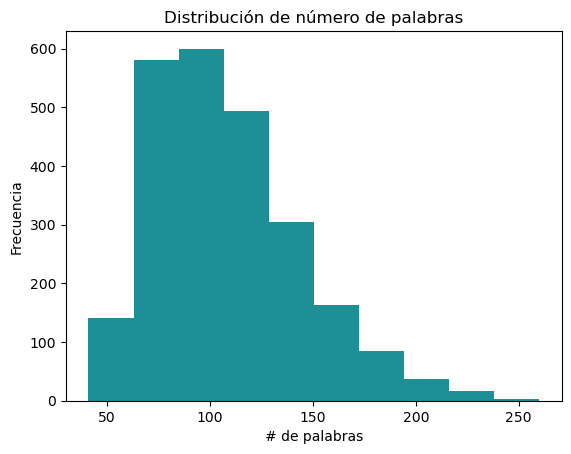

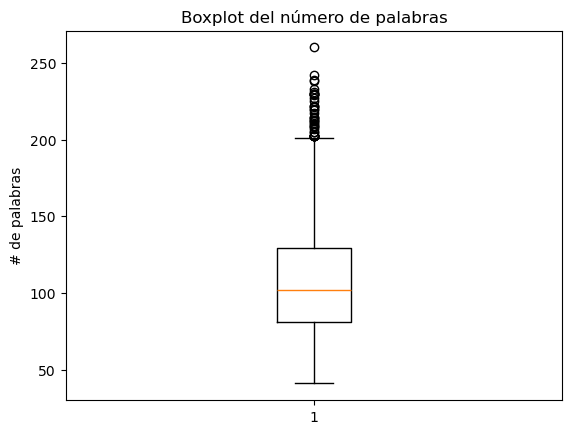

In [224]:
plt.hist(normalized_df["word_count"], color="#1D8F97")
plt.title("Distribución de número de palabras")
plt.xlabel("# de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.boxplot(normalized_df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

## 2.3 Exploración de las palabras más frecuentes y representativas por clase


Se quiere saber cuáles son las palabras más frecuentes en todo el dataset y por clase.


### 2.3.1 Palabras más frecuentes en todo el dataset


,word,frequency
0,ms,1797
1,salud,1108
2,pobreza,1020
3,educacin,995
4,pases,963
5,atencin,900
6,tambin,767
7,estudiantes,742
8,ocde,587
9,escuelas,586


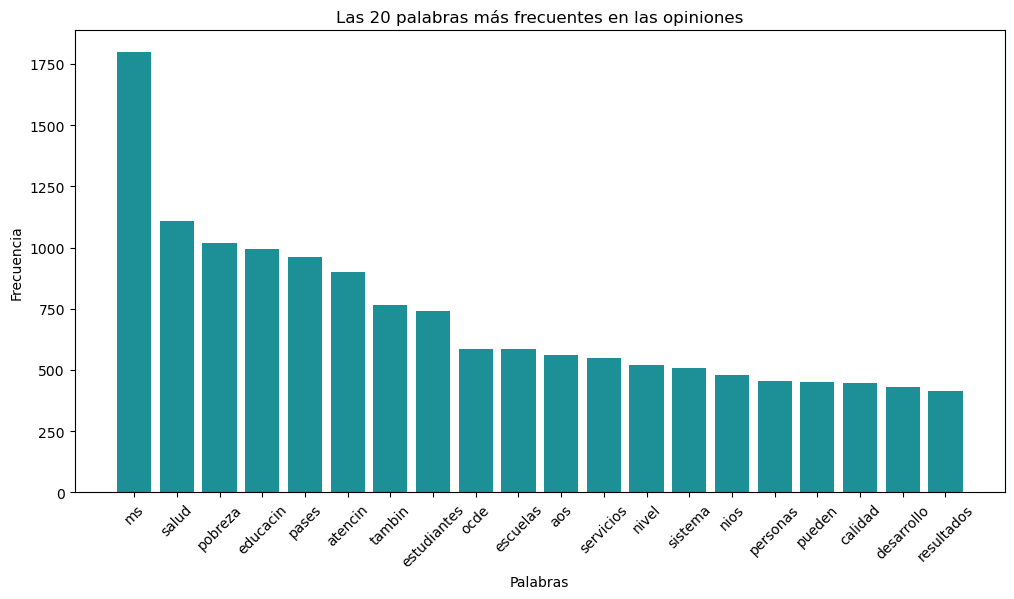

In [225]:
all_tokens = [token for tokens_list in normalized_df["tokens"] for token in tokens_list]

word_counts = Counter(all_tokens)

# Obtener las n palabras más comunes
n_words = 20
most_common_words = word_counts.most_common(n_words)

freq_df = pd.DataFrame(most_common_words, columns=["word", "frequency"])

display(freq_df)

# Graficar las palabras más frecuentes
plt.figure(figsize=(12, 6))
plt.bar(freq_df["word"], freq_df["frequency"], color="#1D8F97")
plt.xticks(rotation=45)
plt.title(f"Las {n_words} palabras más frecuentes en las opiniones")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()

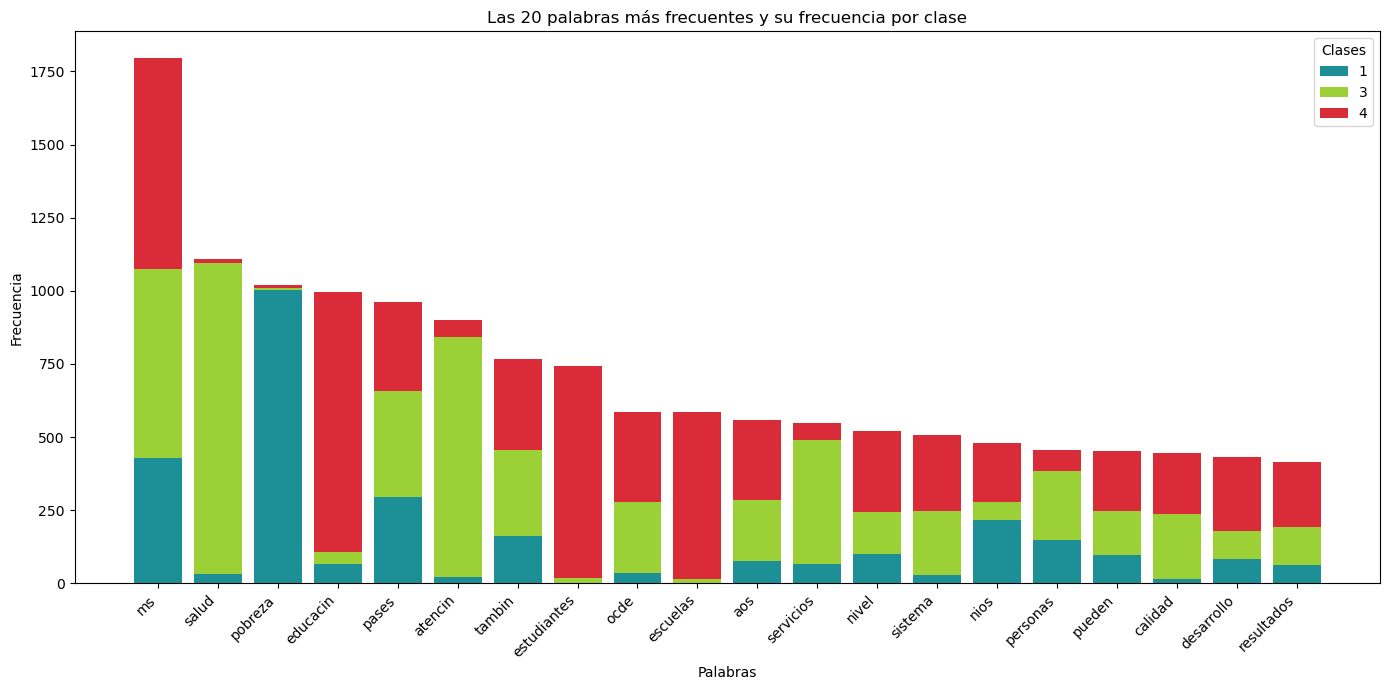

In [226]:
top_words = [word for word, count in most_common_words]

classes = sorted(normalized_df["labels"].unique())  # [1, 3, 4]
class_freq_data = {}

for label in classes:
    class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(class_tokens)

    # por cada una de las palabras del top, encontrar su frecuencia en la clase
    class_freq_data[label] = [class_word_counts.get(word, 0) for word in top_words]

plot_df = pd.DataFrame(class_freq_data, index=top_words)

fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(top_words))  # iniciar la base de las barras en 0

for class_label, frequencies in plot_df.items():
    ax.bar(
        plot_df.index,
        frequencies,
        bottom=bottom,
        label=class_label,
        color=colors[class_label],
    )
    # Añadir la frecuencia a la base de la siguiente iteración
    bottom += frequencies.values

ax.set_title(f"Las {n_words} palabras más frecuentes y su frecuencia por clase")
ax.set_xlabel("Palabras")
ax.set_ylabel("Frecuencia")

ax.set_xticks(ax.get_xticks())  # This can help avoid a UserWarning
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(title="Clases")
plt.tight_layout()
plt.show()

### 2.3.2 Palabras más frecuentes por clase


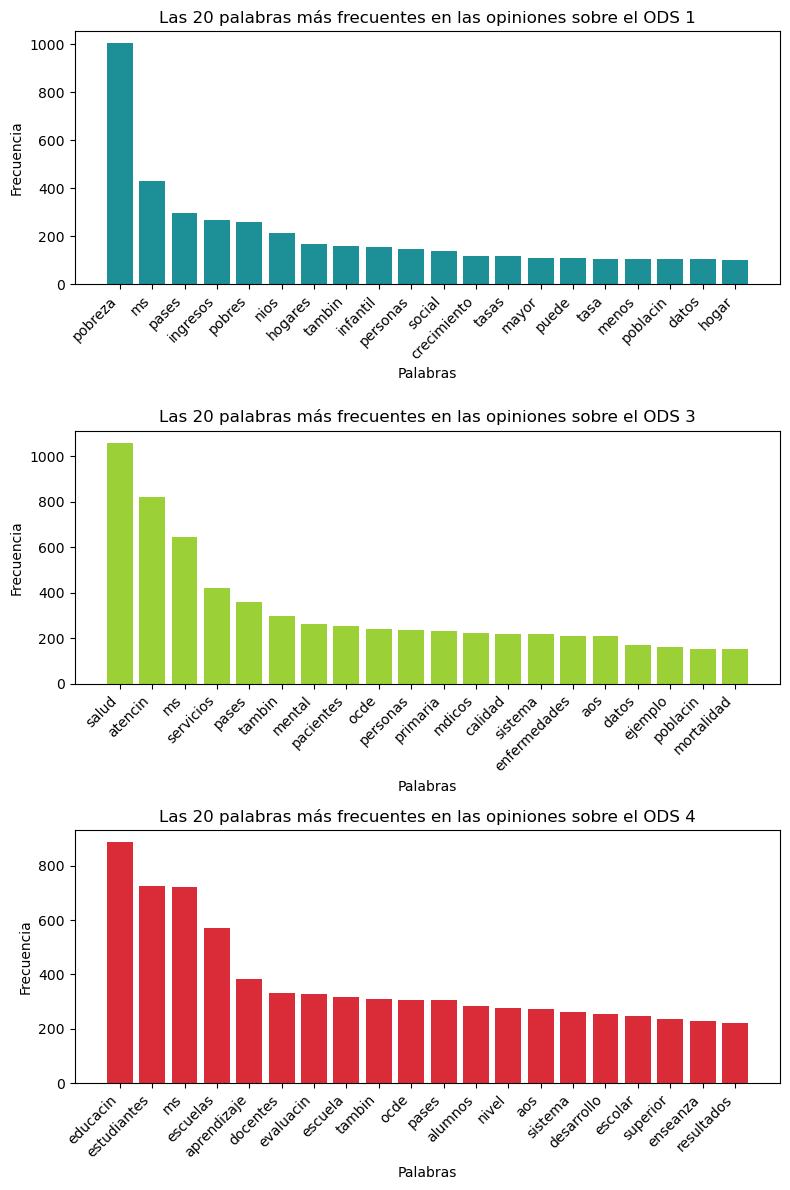

In [227]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

for i, label in enumerate({1, 3, 4}):

    all_class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(all_class_tokens)

    # Obtener las n palabras más comunes
    top_class_words_counts = class_word_counts.most_common(n_words)

    label_freq_df = pd.DataFrame(top_class_words_counts, columns=["word", "frequency"])

    # Graficar las palabras más frecuentes para la clase
    ax[i].bar(label_freq_df["word"], label_freq_df["frequency"], color=colors[label])
    ax[i].set_xticks(ax[i].get_xticks())
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha="right")
    ax[i].set_title(
        f"Las {n_words} palabras más frecuentes en las opiniones sobre el ODS {label}"
    )
    ax[i].set_xlabel("Palabras")
    ax[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

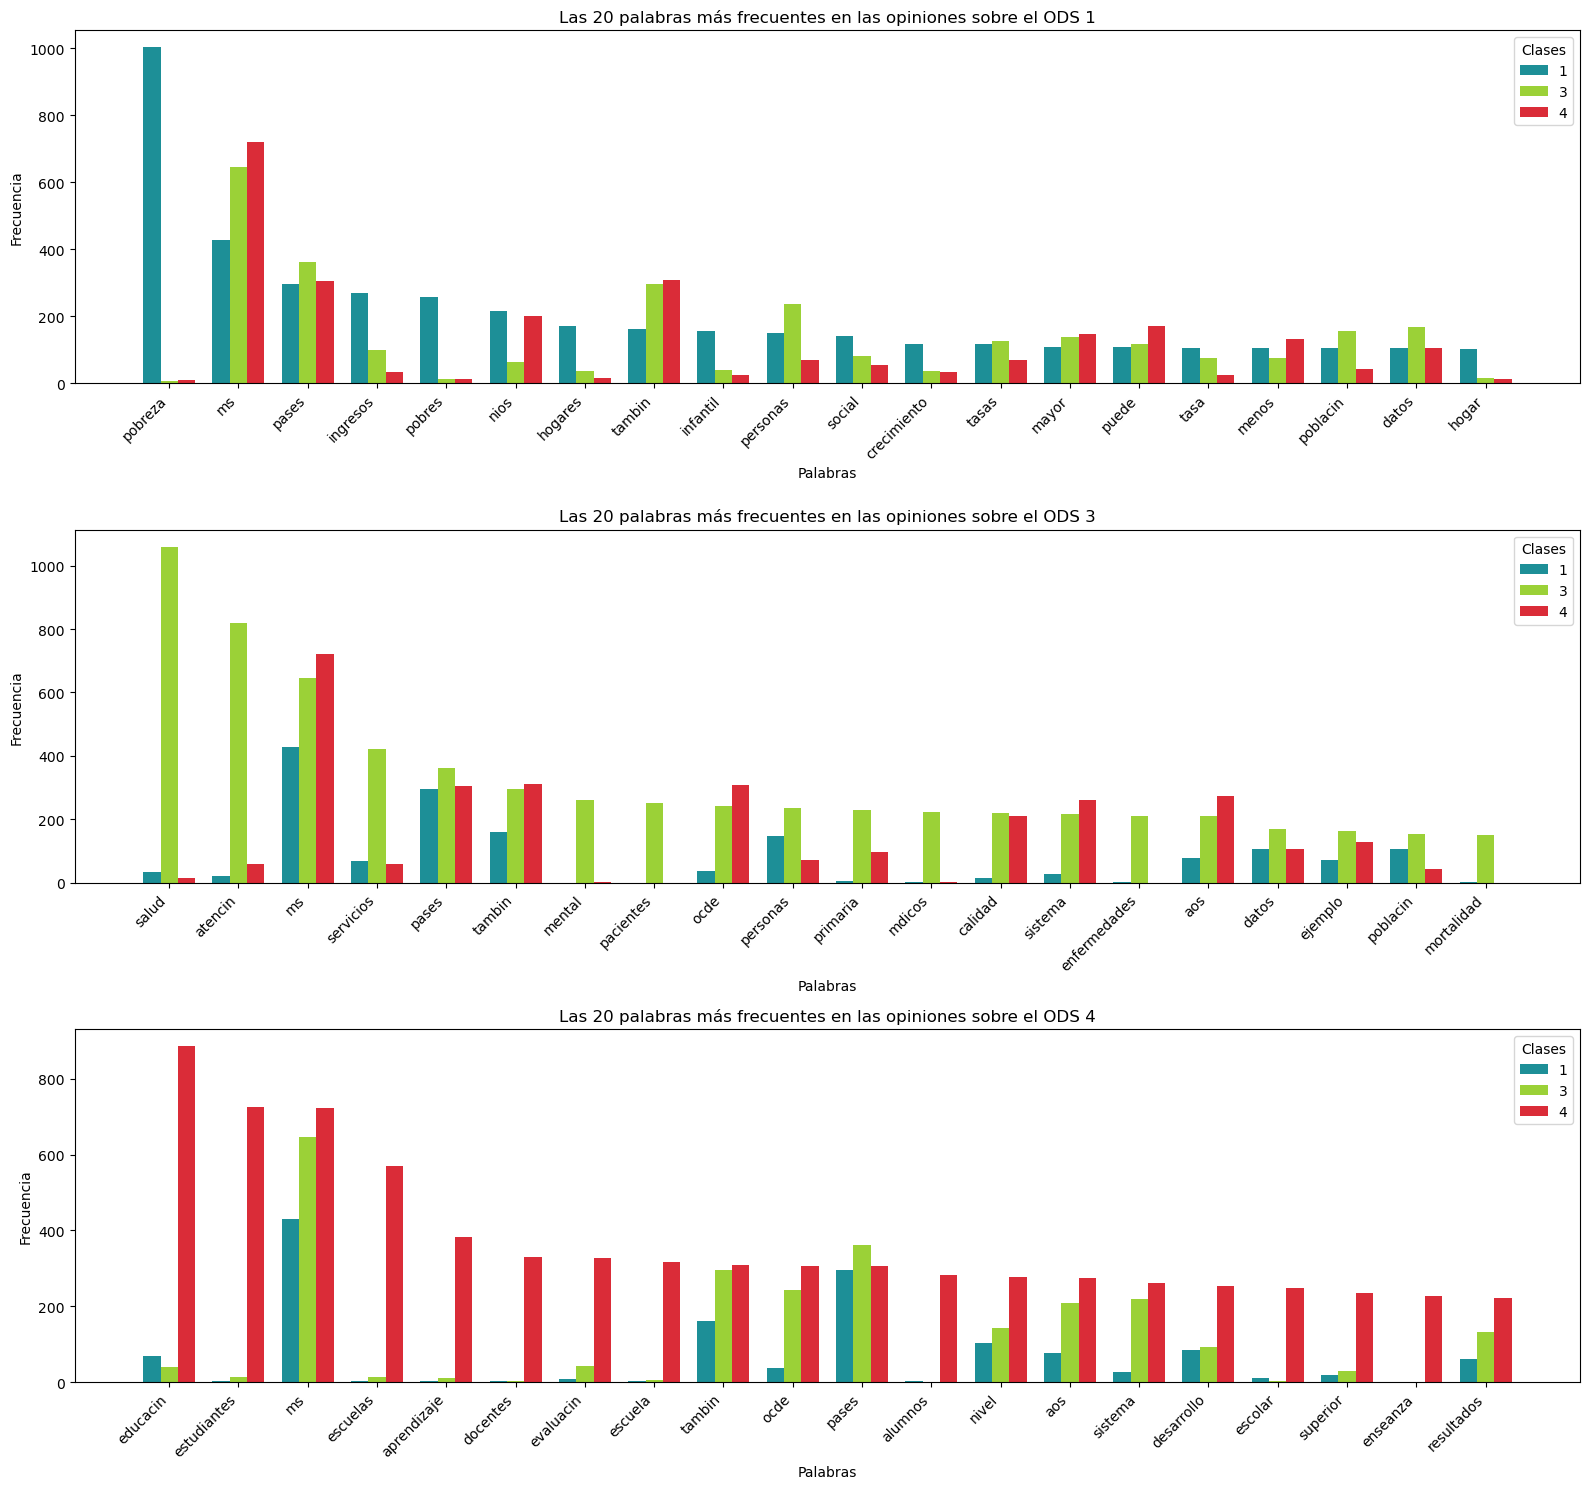

In [228]:
fig, ax = plt.subplots(3, 1, figsize=(16, 15))
bar_width = 0.25
n_classes = len(classes)
for i, label in enumerate({1, 3, 4}):

    all_class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(all_class_tokens)

    # Obtener las n palabras más comunes
    top_class_words_counts = class_word_counts.most_common(n_words)
    
    class_top_words = [word for word, count in top_class_words_counts]
    class_freq_data = {}
    
    for label2 in classes:
        # por cada una de las palabras del top, encontrar su frecuencia en las clases
        class_tokens = [
            token
            for tokens_list in normalized_df[normalized_df["labels"] == label2]["tokens"]
            for token in tokens_list
        ]

        class_word_counts = Counter(class_tokens)

        class_freq_data[label2] = [class_word_counts.get(word, 0) for word in class_top_words]
    
    label_freq_df = pd.DataFrame(class_freq_data, index=class_top_words)
    x_positions = np.arange(len(label_freq_df.index))
    # Graficar las palabras más frecuentes para la clase
    for j, class_name in enumerate(label_freq_df.columns):
        offset = bar_width * (j - (n_classes - 1) / 2.0)
        ax[i].bar(
            x_positions + offset,
            label_freq_df[class_name],
            width=bar_width,
            label=class_name,
            color=colors[class_name]
        )
    ax[i].set_xticks(x_positions)
    ax[i].set_xticklabels(label_freq_df.index, rotation=45, ha="right")
    ax[i].set_title(
        f"Las {n_words} palabras más frecuentes en las opiniones sobre el ODS {label}"
    )
    ax[i].set_xlabel("Palabras")
    ax[i].set_ylabel("Frecuencia")
    ax[i].legend(title="Clases")
    
plt.tight_layout()
plt.show()

In [229]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educacin consideran sinnimos escol...,"[aprendizaje, educacin, consideran, sinnimos, ..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,nios ms pequeos bebs nios pequeos capacitacin ...,"[nios, ms, pequeos, bebs, nios, pequeos, capac..."
2,"Además, la formación de especialistas en medic...",3,93,adems formacin especialistas medicina general ...,"[adems, formacin, especialistas, medicina, gen..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,pases ocde tiende pasar cursos obligatorios op...,"[pases, ocde, tiende, pasar, cursos, obligator..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centr personas padecen trastornos mental...,"[grupo, centr, personas, padecen, trastornos, ..."


Finalmente, antes de empezar con los métodos de extracción de features se realiza el split entre datos de entrenamiento y test con el fin de no producir data leakage y que el procesamiento sea el adecuado. 

In [230]:
X = normalized_df['tokenized_text']
y = normalized_df['labels']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## N-M Gramas

Para empezar diferentes distribuciones de las palabras que pueda entrenar correctamente el modelo, se propone hacer un N-M Gama para ver como se ve la distribución de esta estrategia, y ver si es una posible estructura para predecir correctamente el texto. 

En primer lugar se hace una prueba de 1-3 Gramas que clasifica tanto por unigramas, bigramas y trigramas que permite entender la dispersión general de su comportamiento. Este revisa si hay similitudes entre el BOW ya generado, o si agregar palabras concatenadas más largas permite mejorar la clasificación. 

Asimismo, se hace el análisis sobre solo las palabras más utilizadas para ahorrar tiempo de computo, y para eliminar sesgos que pueden existir dentro de la clasificación

In [231]:
n_top_words = 50  
top_words = [word for word, count in word_counts.most_common(n_top_words)]
bv = CountVectorizer(vocabulary=top_words,ngram_range=(1,3))
bv_matrix = bv.fit_transform(normalized_df["tokenized_text"].tolist())
vocab = bv.get_feature_names_out()
print(vocab)
pd.DataFrame(bv_matrix[:5].toarray(), columns=vocab)

['ms' 'salud' 'pobreza' 'educacin' 'pases' 'atencin' 'tambin'
 'estudiantes' 'ocde' 'escuelas' 'aos' 'servicios' 'nivel' 'sistema'
 'nios' 'personas' 'pueden' 'calidad' 'desarrollo' 'resultados' 'ingresos'
 'aprendizaje' 'mayor' 'puede' 'datos' 'evaluacin' 'embargo' 'estn' 'cada'
 'ejemplo' 'ser' 'docentes' 'primaria' 'programas' 'escuela' 'si'
 'polticas' 'menos' 'tasas' 'parte' 'poblacin' 'est' 'nacional' 'superior'
 'alumnos' 'pobres' 'social' 'nmero' 'informacin' 'mejorar']


,ms,salud,pobreza,educacin,pases,atencin,tambin,estudiantes,ocde,escuelas,...,poblacin,est,nacional,superior,alumnos,pobres,social,nmero,informacin,mejorar
0,1,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,0,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,3,1,1,...,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Como es tanta información no se alcanza a apreciar ninguna información relevante únicamente desde la matriz, por lo que se grafica para poder generar análisis más relevantes. De esta manera, también se distingue entre clases, ya que se quiere saber cuales son los 1-3 gramas más utilizados en cada una de las causas utilizadas para clasificar. 

In [232]:

def comparar_ngrams_por_clase(ngram_range_param):
    bv = CountVectorizer(ngram_range=ngram_range_param)
    labels = sorted(normalized_df["labels"].unique())
    top_n = 15
    fig, axes = plt.subplots(1, len(labels), figsize=(5*len(labels), 4))
    for i, label in enumerate(labels):
        textos_clase = normalized_df[normalized_df["labels"] == label]["tokenized_text"]
        bv_matrix = bv.fit_transform(textos_clase)
        vocab = bv.get_feature_names_out()
        frecuencias = bv_matrix.sum(axis=0)
        frecuencias = np.array(frecuencias).flatten()
        top_indices = frecuencias.argsort()[::-1][:top_n]
        top_ngrams = [vocab[idx] for idx in top_indices]
        top_freqs = [frecuencias[idx] for idx in top_indices]
        sns.barplot(x=top_ngrams, y=top_freqs, color=colors[label], ax=axes[i])
        axes[i].set_xticks(range(len(top_ngrams)))
        axes[i].set_xticklabels(top_ngrams, rotation=45, ha='right')
        axes[i].set_title(f'Top {top_n} n-gramas - Clase {label}')
        axes[i].set_xlabel('n-grama')
        axes[i].set_ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

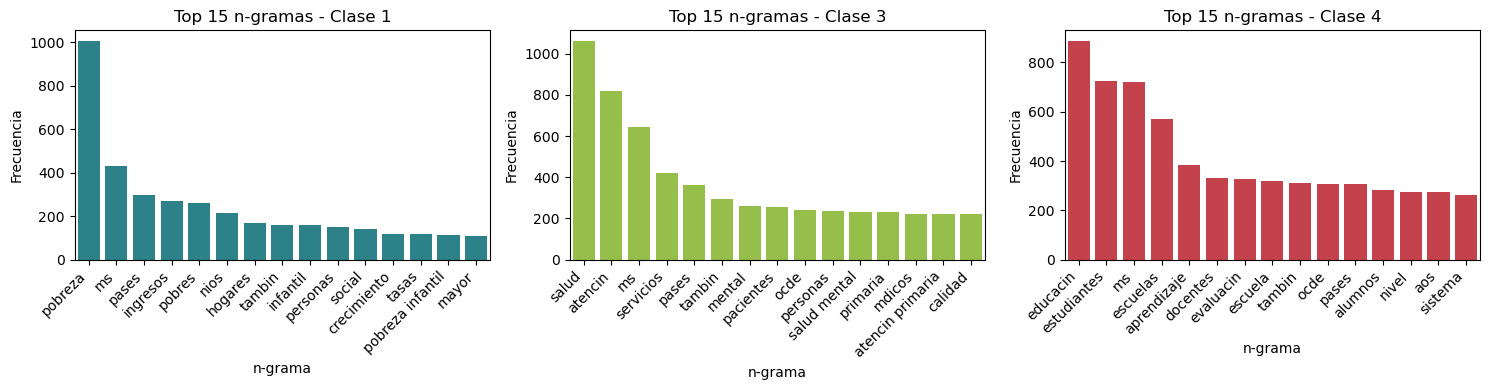

In [233]:
comparar_ngrams_por_clase((1,3))

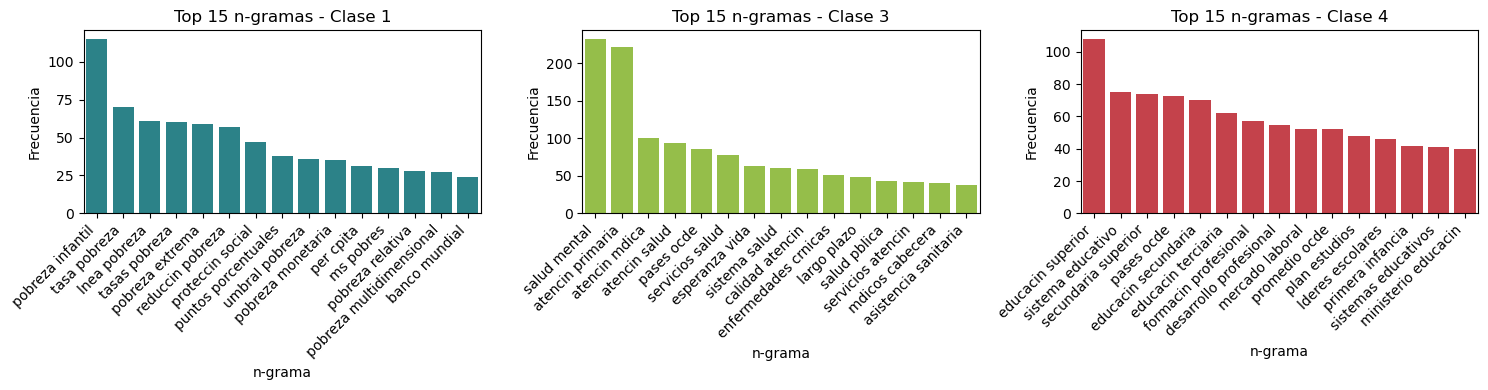

In [234]:
comparar_ngrams_por_clase((2,4))

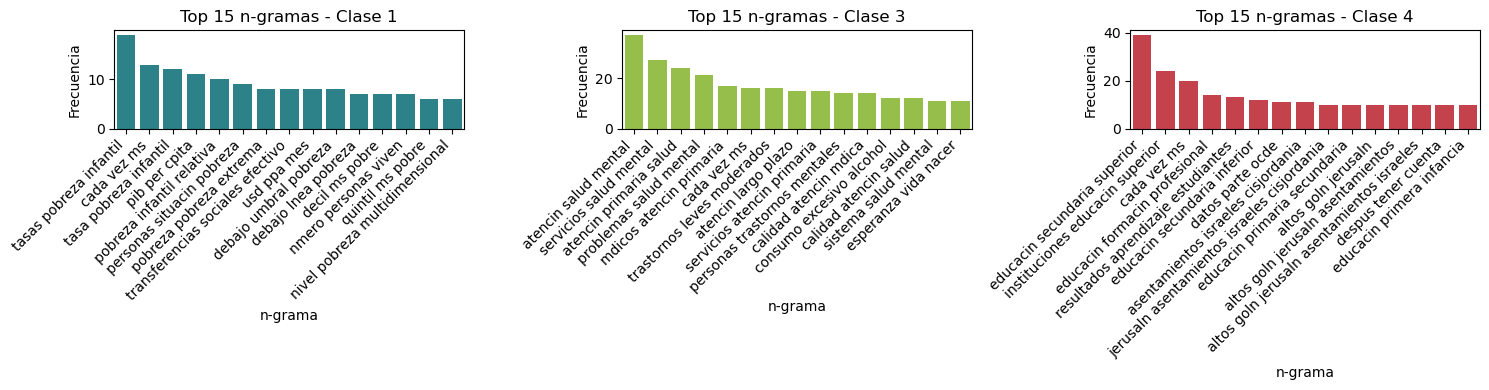

In [235]:
comparar_ngrams_por_clase((3,5))

Estas tres versiones distintas de n-gramas (1-3-grama, 2-4 grama y 3-5 grama) evidencian que la estrategia que más información permite recolectar es un BOW ya que identifica el problema general, y son las palabras que más se repiten. Sin embargo, el uso de los otros n-m gramas ayudan a entender en que orden van estas palabras. Ver esta variación permite ver que un 1-3 n grama es el que más información relevante puede otorgar ya que se ve que cada una de estas (unigramas,bigramas y trigramas) presentan información relevante. 

# TF-IDF para extracción de features

In [236]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf_extraction(X_train_text, vectorizer):

    # Aplicar tf-idf sobre la columna con el texto tokenizado
    tfidf_matrix = vectorizer.fit_transform(X_train_text)


    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train_text.index)
    final_df = tfidf_df
    return final_df, tfidf_matrix

def tf_idf_vectorizar(X_train_text):
    all_tokens = []
    for v in X_train_text:
        for w in v.split():
            all_tokens.append(w.strip())

    word_counts = Counter(all_tokens)

    n_words = 20
    most_common_words = word_counts.most_common(n_words)
    top_words = [word for word, count in most_common_words]

    # Definir vectorizador TF-IDF sobre palabras más comunes
    vectorizer = TfidfVectorizer(vocabulary=top_words)
    return vectorizer

vectorizer = tf_idf_vectorizar(X_train_text)
final_df, tfidf_matrix = tf_idf_extraction(X_train_text, vectorizer)
display(final_df.head())




,ms,salud,pobreza,educacin,pases,atencin,tambin,estudiantes,ocde,escuelas,aos,servicios,nivel,nios,sistema,pueden,calidad,personas,resultados,desarrollo
2200,0.000000,0.743942,0.000000,0.0,0.000000,0.0,0.668244,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1844,0.000000,0.000000,0.947904,0.0,0.158911,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.188502,0.0,0.201722,0.0,0.0
1852,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.288669,0.708896,0.0,0.384023,0.367281,0.0,0.000000,0.0,0.362998,0.000000,0.0,0.000000,0.0,0.0
2344,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2004,0.314377,0.000000,0.000000,0.0,0.000000,0.0,0.809246,0.000000,0.0,0.000000,0.000000,0.0,0.496274,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


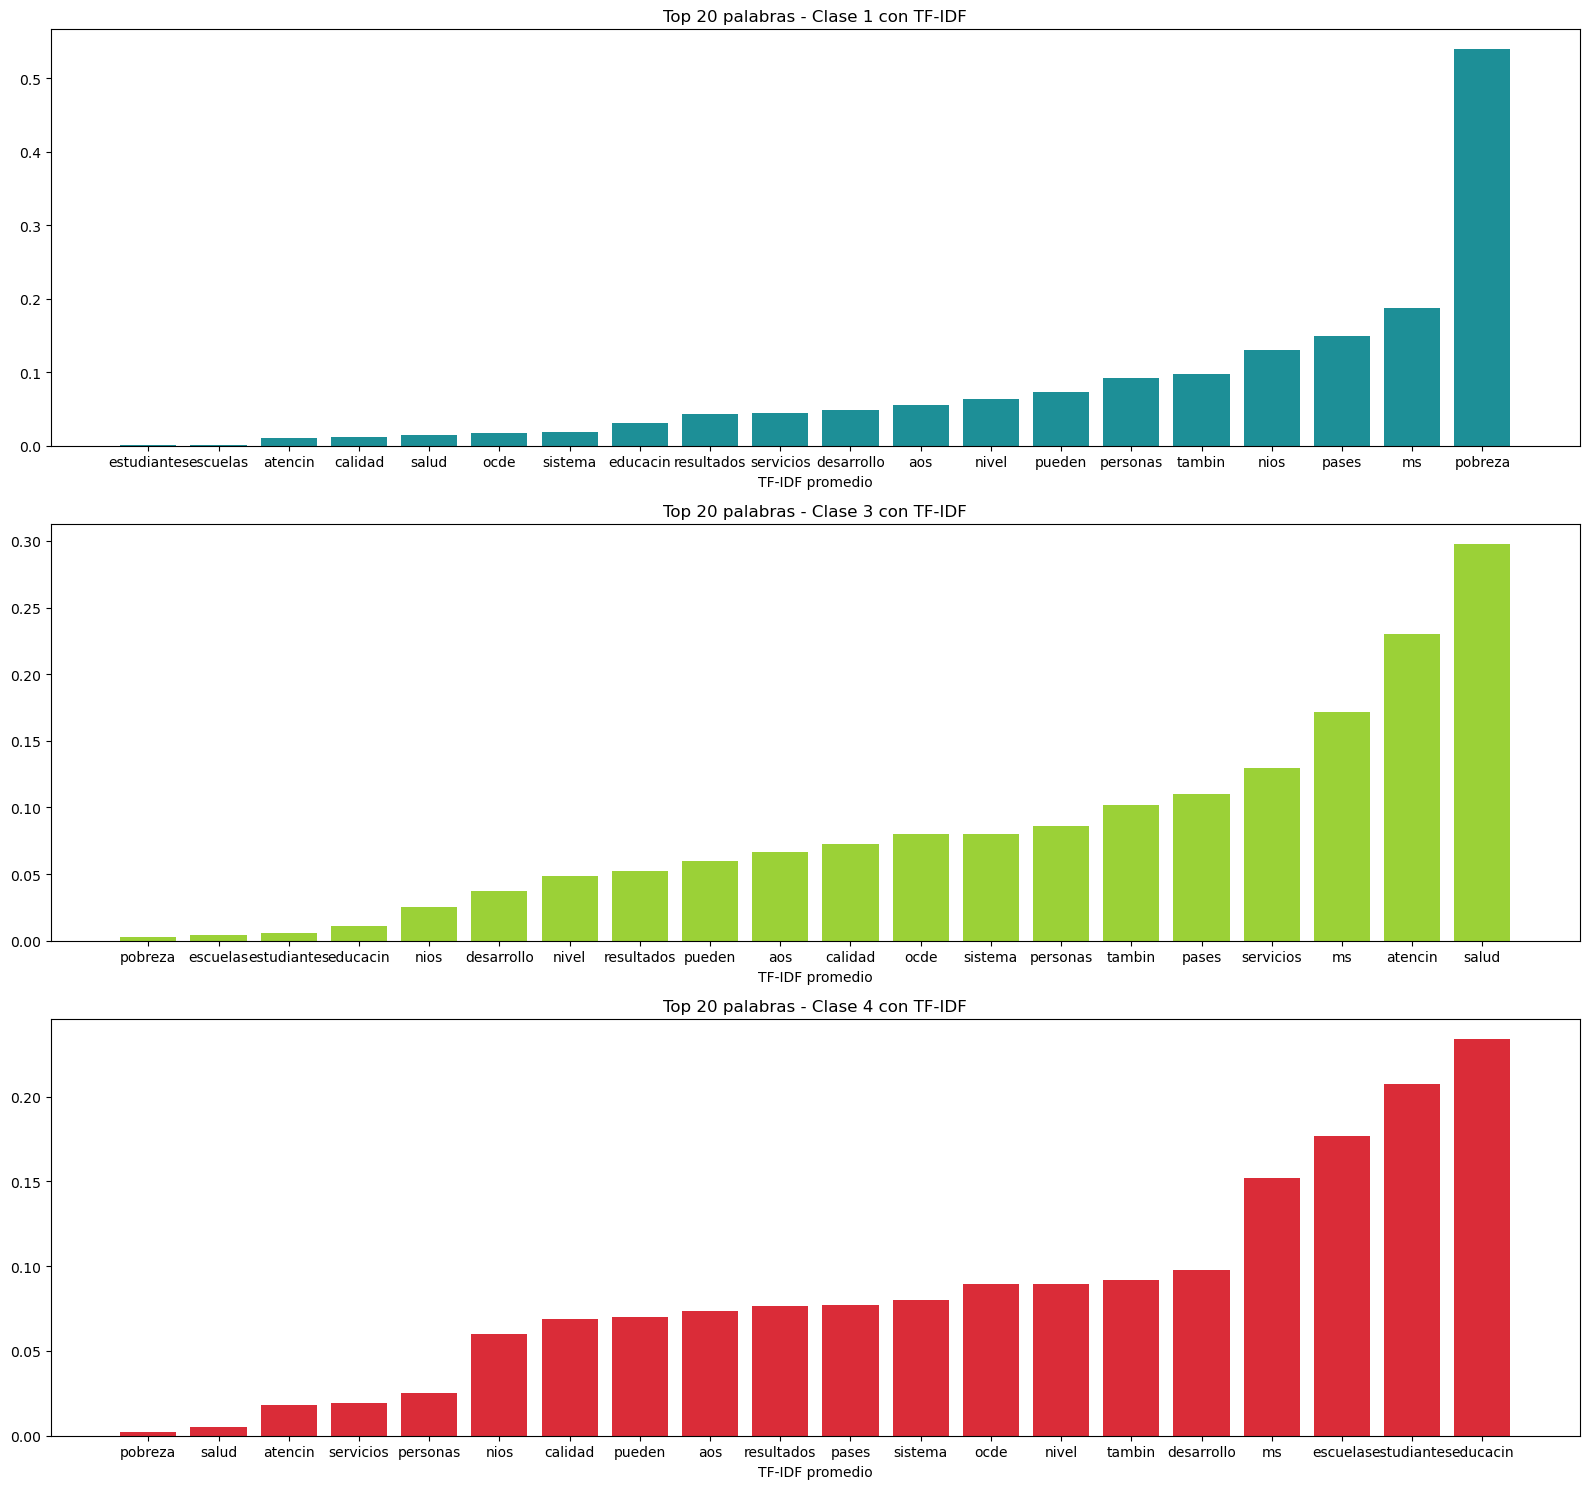

In [237]:
final_df = pd.concat([y_train, final_df], axis=1)
class_tfidf = final_df.groupby("labels").mean()

top_n = 20
fig, axes = plt.subplots(3,1, figsize=(16,15))

for i, label in enumerate(class_tfidf.index):
    top_features = class_tfidf.loc[label].sort_values(ascending=False)[:top_n]
    axes[i].bar(top_features.index[::-1], top_features.values[::-1], color=colors[label])
    axes[i].set_title(f"Top {top_n} palabras - Clase {label} con TF-IDF")
    axes[i].set_xlabel("TF-IDF promedio")

plt.tight_layout()
plt.show()

## Document Similarity

Otra estrategia conocida para agrupar texto es el document similarity, que permite ver como se parecen las palabras entre si, muy útil para entrenar modelos no supervisados. Aunque este no es ese caso, si se desea estudiar esta estrategia para ver el comportamiento del texto, y ver cual va a ser su comportamiento general al momento de clasificarlo. Para esto se crea una matriz de similitud y luego se grafica. 

In [238]:
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938
0,1.000000,0.000000,0.192901,0.0,0.540774,0.623743,0.181953,0.272528,0.267553,0.0,...,0.107711,0.410904,0.149416,0.000000,0.104746,0.171623,0.108165,0.000000,0.000000,0.515308
1,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.066678,0.0,...,0.000000,0.000000,0.907359,0.055189,0.036731,0.000000,0.000000,0.000000,0.073035,0.000000
2,0.192901,0.000000,1.000000,0.0,0.233604,0.120321,0.202890,0.472714,0.115578,0.0,...,0.375909,0.079264,0.169031,0.240639,0.045248,0.297688,0.684181,0.000000,0.291288,0.145376
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.540774,0.000000,0.233604,0.0,1.000000,0.337304,0.220346,0.330033,0.519602,0.0,...,0.169808,0.456411,0.180943,0.286710,0.203422,0.520489,0.229513,0.289109,0.076128,0.075988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,0.171623,0.000000,0.297688,0.0,0.520489,0.107049,0.578407,0.449962,0.102829,0.0,...,0.041396,0.408803,0.057425,0.363967,0.328221,1.000000,0.618862,0.662674,0.000000,0.142880
1935,0.108165,0.000000,0.684181,0.0,0.229513,0.180158,0.434233,0.577422,0.176608,0.0,...,0.159684,0.185543,0.036192,0.243803,0.067751,0.618862,1.000000,0.433957,0.084264,0.000000
1936,0.000000,0.000000,0.000000,0.0,0.289109,0.000000,0.470187,0.332486,0.000000,0.0,...,0.000000,0.196195,0.000000,0.528567,0.000000,0.662674,0.433957,1.000000,0.000000,0.000000
1937,0.000000,0.073035,0.291288,0.0,0.076128,0.216984,0.000000,0.000000,0.150660,0.0,...,0.114236,0.194605,0.333318,0.236042,0.216081,0.000000,0.084264,0.000000,1.000000,0.372450


In [239]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=[r'Document\Cluster 1', r'Document\Cluster 2',
                         r'Distance', r'Cluster Size'], dtype="object")

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,0.0,206.0,0.0,2.0
1,3.0,9.0,0.0,2.0
2,427.0,1000.0,0.0,2.0
3,1455.0,1941.0,0.0,3.0
4,1793.0,1942.0,0.0,4.0
...,...,...,...,...
1933,3867.0,3869.0,100.843213,732.0
1934,3853.0,3871.0,111.308716,493.0
1935,3872.0,3873.0,137.312438,1225.0
1936,3870.0,3874.0,206.437443,1665.0


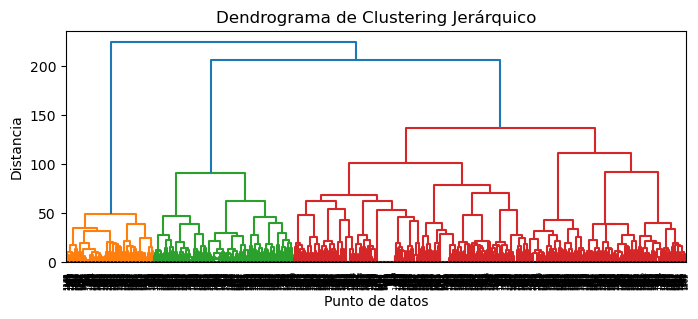

In [240]:
plt.figure(figsize=(8, 3))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Punto de datos')
plt.ylabel('Distancia')
dendrogram(Z)
plt.axhline(y=1.0, c="k", ls="--", lw=0.5)

Este resultado señala que hay conexiones entre el texto, donde entre mas bajo se encuentren en el árbol, más se parecen entre si. Las partes naranjas/verdes en la parte inferior muestran documentos muy similares entre sí mientras que las conexiones rojas en la parte superior indican grupos más grandes pero menos cohesionados. La altura mayor de las conexiones rojas sugiere mayor disimilitud entre estos grupos.

Esto nos dice que existen algunos grupos pequeños de documentos muy similares (clusters bajos) y hay una clara estructura jerárquica con 3 grupos principales. Este primer acercamiento resulta muy coherente con la clasificación de 3 grupos ODS que deseamos hacer. Asimismo, la altura de las conexiones sugiere que los documentos dentro de cada grupo principal son relativamente diferentes entre sí.

Esto nos dice que el dataset cuenta con diferencias lo suficientemente marcadas para generara una clasificación satisfactoria. 

# Word2Vec

In [241]:
from gensim.models import Word2Vec

def document_vector(doc, model):
    doc_new = []
    for word in doc:
        if word in model.wv.key_to_index:
            doc_new.append(word)
    if len(doc_new) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(model.wv[doc_new], axis=0)
    
def generate_features_w2v(model, corpus):
    vectors = []
    for text in corpus:
        doc_vec = document_vector(text, model)
        vectors.append(doc_vec)
    return np.array(vectors)

def word2vec_function(X_train_text):
    corpus = []
    for text in X_train_text:
        corpus.append(text.split())
    model = Word2Vec(sentences=corpus, vector_size=200, window=2, min_count=1, sg=0)
    return model, corpus


model_w2v, corpus_w2v = word2vec_function(X_train_text)
X_word2vec = generate_features_w2v(model_w2v, corpus_w2v)
display(X_word2vec)

array([[ 0.08182664, -0.07300956,  0.03415637, ..., -0.17316316,
        -0.00923698, -0.03739664],
       [ 0.08882634, -0.08966643,  0.04168022, ..., -0.19976836,
        -0.00585647, -0.04869702],
       [ 0.10454505, -0.09866178,  0.04786227, ..., -0.21853031,
        -0.00638628, -0.05086986],
       ...,
       [ 0.09163847, -0.08573398,  0.04140736, ..., -0.18855952,
        -0.00906111, -0.04400273],
       [ 0.0825472 , -0.07885752,  0.03691923, ..., -0.17317584,
        -0.00779022, -0.03992304],
       [ 0.07639504, -0.06865297,  0.03214067, ..., -0.1619486 ,
        -0.00635014, -0.03633378]], dtype=float32)

# Multinomial Naïve Bayes 

Explorado por: Maria Alejandra Angulo Mejia 

El algoritmo Multinomial Naïve Bayes es un método probabilístico de clasificación que se basa en el Teorema de Bayes. Asume que las características (en este caso, las palabras) son independientes entre sí dentro de un documento. El modelo calcula la probabilidad de que un texto pertenezca a una clase (por ejemplo, un ODS) a partir de la frecuencia con la que aparecen las palabras en ese texto y en los documentos de entrenamiento de cada clase.

El término “multinomial” hace referencia a que el algoritmo se adapta especialmente a variables de conteo, como la cantidad de veces que aparece cada palabra. Así, si una palabra aparece con mayor frecuencia en documentos de cierta categoría, el modelo le asignará más peso a esa relación.

Entre sus ventajas están su simplicidad, eficiencia y buen desempeño en clasificación de texto, incluso con conjuntos de datos grandes y vocabularios amplios. Sin embargo, suponer independencia entre palabras es una limitación, ya que en el lenguaje natural muchas veces los términos están correlacionados.

Para estudiar su efectividad se prueba haciendo una clasificación con un BOW, 1-3 Grama, 1-5 Grama por el análisis hecho anteriormente, y con TF-IDF para ver cual genera mejores resultados. Se espera que 1-3 Gramas ayude a mitigar el supuesto de independencia de Naive Bayes. 

## con N-M-Gramas

In [242]:
def n_grama(n_grama_param):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_ngram = vectorizer_ngram.fit_transform(normalized_df['tokenized_text'].fillna(''))
    y = normalized_df['labels']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_ngram, y, test_size=0.2, random_state=42)

    # Modelo
    nb_ngram = MultinomialNB()
    nb_ngram.fit(X_train, y_train)
    y_pred_ngram = nb_ngram.predict(X_test)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred_ngram, average="macro"))
    print("Accuracy:", accuracy_score(y_test, y_pred_ngram))
    print("Recall:", recall_score(y_test, y_pred_ngram, average="macro"))
    print(classification_report(y_test, y_pred_ngram))

In [243]:
n_grama((1,3))
print("===============================")
n_grama((1,5))

N-grama (1, 3):
F1 score: 0.9613821891820075
Accuracy: 0.9649484536082474
Recall: 0.9634581881533101
              precision    recall  f1-score   support

           1       0.92      0.96      0.94       112
           3       0.98      0.96      0.97       168
           4       0.98      0.97      0.98       205

    accuracy                           0.96       485
   macro avg       0.96      0.96      0.96       485
weighted avg       0.97      0.96      0.97       485

N-grama (1, 5):
F1 score: 0.939793187758094
Accuracy: 0.9443298969072165
Recall: 0.9518002322880372
              precision    recall  f1-score   support

           1       0.82      1.00      0.90       112
           3       0.98      0.93      0.95       168
           4       1.00      0.93      0.96       205

    accuracy                           0.94       485
   macro avg       0.93      0.95      0.94       485
weighted avg       0.95      0.94      0.95       485



## Con TF-IDF

In [244]:
vectorizer = tf_idf_vectorizar(X_train_text)
tfidf_matrix_train = vectorizer.fit_transform(X_train_text)
tfidf_matrix_test = vectorizer.transform(X_test_text)

# Modelo
nb_tfidf = MultinomialNB()
nb_tfidf.fit(tfidf_matrix, y_train)
y_pred_tfidf = nb_tfidf.predict(tfidf_matrix_test)

# Métricas
print("TF-IDF (1,3):")
print("F1 score:", f1_score(y_test, y_pred_tfidf, average="macro"))
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("Recall:", recall_score(y_test, y_pred_tfidf, average="macro"))
print(classification_report(y_test, y_pred_tfidf))

TF-IDF (1,3):
F1 score: 0.8612582643245009
Accuracy: 0.8618556701030928
Recall: 0.8507742934572202
              precision    recall  f1-score   support

           1       0.97      0.79      0.87       112
           3       0.80      0.87      0.83       168
           4       0.87      0.90      0.88       205

    accuracy                           0.86       485
   macro avg       0.88      0.85      0.86       485
weighted avg       0.87      0.86      0.86       485



# Logistic Regression With TF-IDF
Se realiza un modelo con el uso de logistic regression y se calculan sus métricas. Se utilizan los datos preparados con TF-IDF para esto. 

In [245]:
vectorizer = tf_idf_vectorizar(X_train_text)
tfidf_matrix_train = vectorizer.fit_transform(X_train_text)
tfidf_matrix_test = vectorizer.transform(X_test_text)

log_reg = LogisticRegression(solver="saga", max_iter=1_000)
log_reg.fit(tfidf_matrix_train, y_train)

pred_labels = log_reg.predict(tfidf_matrix_test)
f1_macro = f1_score(y_test, pred_labels, average="macro")
accuracy = accuracy_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels, average="macro")

print("F1 score: ", f1_macro)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print(classification_report(y_test, pred_labels))



F1 score:  0.8573719688955354
Accuracy:  0.8556701030927835
Recall:  0.8508275261324041
              precision    recall  f1-score   support

           1       0.96      0.79      0.87       112
           3       0.75      0.93      0.83       168
           4       0.92      0.83      0.87       205

    accuracy                           0.86       485
   macro avg       0.88      0.85      0.86       485
weighted avg       0.87      0.86      0.86       485



# Logistic Regression with Word2Vec

In [246]:
model_w2v, corpus_w2v = word2vec_function(X_train_text)

X_train_w2v = generate_features_w2v(model_w2v, corpus_w2v)

corpus_test = []
for text in X_test_text:
    corpus_test.append(text.split())

X_test_w2v = generate_features_w2v(model_w2v, corpus_test)


# Modelo
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_w2v, y_train)

# Evaluación
y_pred = clf.predict(X_test_w2v)
f1_macro = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="macro")
print("F1 score: ", f1_macro)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print(classification_report(y_test, y_pred))



F1 score:  0.6916589186921397
Accuracy:  0.6948453608247422
Recall:  0.6937475803329463
              precision    recall  f1-score   support

           1       0.66      0.70      0.68       112
           3       0.69      0.67      0.68       168
           4       0.72      0.71      0.71       205

    accuracy                           0.69       485
   macro avg       0.69      0.69      0.69       485
weighted avg       0.70      0.69      0.69       485



# Logistic Regression with N-Grams

In [247]:
def logistic_n_gram(n_grama_param, X_train, X_test, y_train, y_test):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_train_ngram = vectorizer_ngram.fit_transform(X_train.fillna(''))
    X_test_ngram = vectorizer_ngram.transform(X_test.fillna(''))

    # Modelo
    log_n = LogisticRegression(max_iter=1000)
    log_n.fit(X_train_ngram, y_train)
    y_pred = log_n.predict(X_test_ngram)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred, average="macro"))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print(classification_report(y_test, y_pred))

logistic_n_gram((1,3), X_train_text, X_test_text, y_train, y_test)
print("===============================")
logistic_n_gram((1,5), X_train_text, X_test_text, y_train, y_test)

N-grama (1, 3):
F1 score: 0.9660570598198398
Accuracy: 0.9690721649484536
Recall: 0.9627419667053814
              precision    recall  f1-score   support

           1       0.98      0.92      0.95       112
           3       0.95      0.99      0.97       168
           4       0.98      0.98      0.98       205

    accuracy                           0.97       485
   macro avg       0.97      0.96      0.97       485
weighted avg       0.97      0.97      0.97       485

N-grama (1, 5):
F1 score: 0.956536640057846
Accuracy: 0.9608247422680413
Recall: 0.9518292682926829
              precision    recall  f1-score   support

           1       0.98      0.89      0.93       112
           3       0.94      0.98      0.96       168
           4       0.97      0.98      0.98       205

    accuracy                           0.96       485
   macro avg       0.96      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485

